In [63]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd

# Config de visualización
plt.rcParams['figure.figsize'] = (6, 6)
plt.rcParams['axes.grid'] = False

## Parámetros

In [64]:

# Ruta del template y carpeta/archivos a procesar
PATTERN_PATH = Path('pattern.png')  # ajusta si es necesario
IMAGE_GLOBS = ['*.png', '*.jpg', '*.jpeg', '*.bmp']  # patrones a buscar
# O lista explícita, ejemplo: IMAGE_LIST = [Path('coca_retro_2.png'), Path('coca_logo_1.png')]
IMAGE_LIST = ['coca_logo_1.png','coca_multi.png','coca_retro_2.png','logo_1.png','COCA-COLA-LOGO.jpg']  # si no está vacío, se usa esta lista en vez de los globs

# Template Matching 
TM_METHOD = cv2.TM_CCORR_NORMED
TM_SCALES = np.linspace(0.35, 1.75, 36)[::-1]  # multiescala
TM_MIN_CONF = 0.60  # umbral de aceptación para TM

# ORB fallback
ORB_N_FEATURES = 1500
ORB_FAST_THRESHOLD = 15
ORB_MIN_MATCHES = 30         # mínimo de matches brutos para intentar homografía
ORB_MIN_INLIERS = 15         # mínimo de inliers para aceptar detección
ORB_RANSAC_REPROJ_TH = 3.0   # reproyección para RANSAC (px)

# Visualización
SHOW_KEYPOINTS = False  # si True, muestra keypoints ORB en el plot adicional

## Funciones auxiliares

In [65]:

def auto_canny(image, sigma=5):
    v = np.median(image)
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    return cv2.Canny(image, lower, upper, L2gradient=True)

def prep_edges(img_bgr):
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (3,3), 0)
    return auto_canny(gray)

def best_match_multiscale(target_edges, template_edges, scales, method=cv2.TM_CCORR_NORMED):
    H, W = target_edges.shape[:2]
    h_t, w_t = template_edges.shape[:2]
    best = {"max_val": -1.0, "max_loc": None, "w": None, "h": None, "scale": None}
    for scale in scales:
        new_w, new_h = int(w_t*scale), int(h_t*scale)
        if new_w < 12 or new_h < 12 or new_w >= W or new_h >= H:
            continue
        resized = cv2.resize(template_edges, (new_w, new_h),
                             interpolation=cv2.INTER_AREA if scale<1 else cv2.INTER_CUBIC)
        res = cv2.matchTemplate(target_edges, resized, method)
        _, max_val, _, max_loc = cv2.minMaxLoc(res)
        if max_val > best["max_val"]:
            best.update({"max_val": float(max_val), "max_loc": max_loc,
                         "w": new_w, "h": new_h, "scale": float(scale)})
    return best

def run_orb_homography(img_bgr, tmpl_bgr,
                       n_features=1500, fast_th=15,
                       min_matches=30, ransac_th=3.0):
    # ORB
    orb = cv2.ORB_create(nfeatures=n_features, fastThreshold=fast_th)
    img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    tmpl_gray = cv2.cvtColor(tmpl_bgr, cv2.COLOR_BGR2GRAY)
    kp1, des1 = orb.detectAndCompute(tmpl_gray, None)
    kp2, des2 = orb.detectAndCompute(img_gray, None)
    if des1 is None or des2 is None or len(kp1) == 0 or len(kp2) == 0:
        return {"ok": False, "matches": 0, "inliers": 0, "H": None, "corners": None, "kp": (kp1, kp2), "matches_raw": []}

    # Bruteforce-Hamming matcher con crossCheck 
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des1, des2)
    matches = sorted(matches, key=lambda x: x.distance)
    if len(matches) < min_matches:
        return {"ok": False, "matches": len(matches), "inliers": 0, "H": None, "corners": None, "kp": (kp1, kp2), "matches_raw": matches}

    # Homografía con RANSAC
    src_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1,1,2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1,1,2)
    H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, ransac_th)
    if H is None or mask is None:
        return {"ok": False, "matches": len(matches), "inliers": 0, "H": None, "corners": None, "kp": (kp1, kp2), "matches_raw": matches}
    inliers = int(mask.ravel().sum())

    # Proyectar esquinas del template
    h_t, w_t = tmpl_gray.shape[:2]
    corners_t = np.float32([[0,0],[w_t,0],[w_t,h_t],[0,h_t]]).reshape(-1,1,2)
    corners_img = cv2.perspectiveTransform(corners_t, H)

    return {"ok": True, "matches": len(matches), "inliers": inliers, "H": H,
            "corners": corners_img, "kp": (kp1, kp2), "matches_raw": matches}

def draw_tm_box(img_bgr, top_left, w, h, conf, conf_th):
    out = img_bgr.copy()
    if top_left is not None and w and h:
        color = (0,255,0) if conf>=conf_th else (0,255,255)
        cv2.rectangle(out, top_left, (top_left[0]+w, top_left[1]+h), color, 2)
        label = f"Coca-Cola: {conf:.3f}" if conf>=conf_th else f"mejor={conf:.3f} (<{conf_th})"
        cv2.putText(out, label, (top_left[0], max(0, top_left[1]-10)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2, cv2.LINE_AA)
    return out

def draw_orb_polygon(img_bgr, corners, inliers, total_matches):
    out = img_bgr.copy()
    if corners is not None:
        corners = corners.astype(int).reshape(-1,2)
        for i in range(4):
            p1 = tuple(corners[i])
            p2 = tuple(corners[(i+1)%4])
            cv2.line(out, p1, p2, (0,255,0), 2)
        cv2.putText(out, f"ORB inliers={inliers}/{total_matches}", (corners[0][0], max(0, corners[0][1]-10)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0), 2, cv2.LINE_AA)
    return out

## Cargar template y listado de imágenes

In [66]:

tmpl_bgr = cv2.imread(str(PATTERN_PATH))
if tmpl_bgr is None:
    raise FileNotFoundError(f"No se pudo leer el template: {PATTERN_PATH}")

# Construir lista de imágenes
images = []
if IMAGE_LIST:
    images = [Path(p) for p in IMAGE_LIST]
else:
    for g in IMAGE_GLOBS:
        images.extend(sorted(IMAGES_DIR.glob(g)))
if not images:
    raise FileNotFoundError(f"No se encontraron imágenes en {IMAGES_DIR} con globs {IMAGE_GLOBS}")

print("Se procesarán", len(images), "imágenes.")
for p in images[:5]:
    print(" -", p)


Se procesarán 5 imágenes.
 - coca_logo_1.png
 - coca_multi.png
 - coca_retro_2.png
 - logo_1.png
 - COCA-COLA-LOGO.jpg


## Procesamiento: Template Matching → ORB (respaldo)

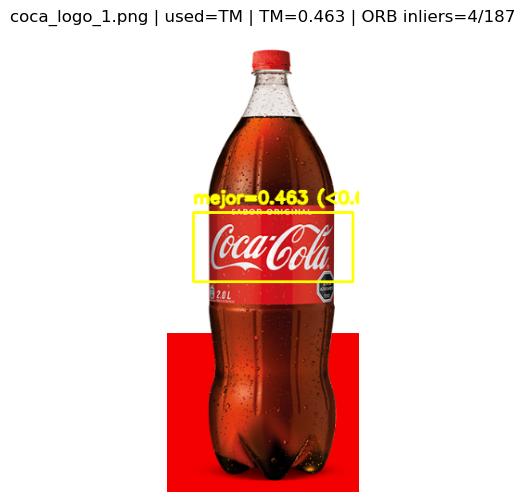

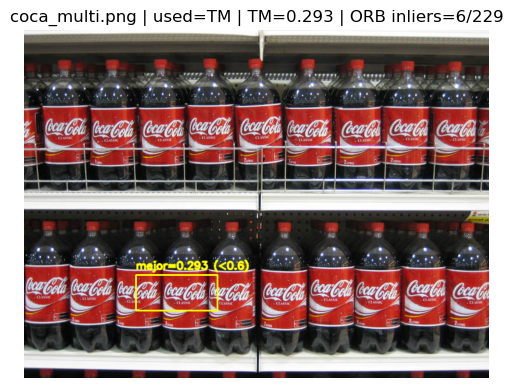

[ERROR] No se pudo leer coca_retro_2.png
[ERROR] No se pudo leer logo_1.png


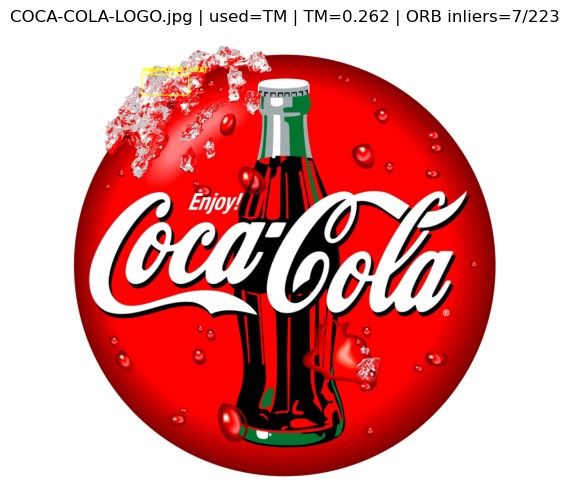

In [67]:

results = []

# Preprocesar template para TM (bordes)
edges_tmpl = prep_edges(tmpl_bgr)

for img_path in images:
    img_bgr = cv2.imread(str(img_path))
    if img_bgr is None:
        print(f"[ERROR] No se pudo leer {img_path}")
        continue

    
    edges_img = prep_edges(img_bgr)
    best = best_match_multiscale(edges_img, edges_tmpl, TM_SCALES, method=TM_METHOD)
    tm_conf = float(best["max_val"]) if best["max_val"] is not None else 0.0
    tm_pt = best["max_loc"]
    tm_w, tm_h = best["w"], best["h"]

    
    used = "TM"
    final_image = draw_tm_box(img_bgr, tm_pt, tm_w, tm_h, tm_conf, TM_MIN_CONF)
    orb_matches = 0
    orb_inliers = 0
    orb_ok = False

    if not (tm_conf >= TM_MIN_CONF and tm_pt is not None and tm_w and tm_h):
        # ORB fallback
        orb_res = run_orb_homography(img_bgr, tmpl_bgr,
                                     n_features=ORB_N_FEATURES, fast_th=ORB_FAST_THRESHOLD,
                                     min_matches=ORB_MIN_MATCHES, ransac_th=ORB_RANSAC_REPROJ_TH)
        orb_ok = orb_res["ok"]
        orb_matches = orb_res["matches"]
        orb_inliers = orb_res["inliers"]
        if orb_ok and orb_inliers >= ORB_MIN_INLIERS:
            used = "ORB"
            final_image = draw_orb_polygon(img_bgr, orb_res["corners"], orb_inliers, orb_matches)

    
    plt.figure()
    plt.imshow(cv2.cvtColor(final_image, cv2.COLOR_BGR2RGB))
    title = f"{img_path.name} | used={used} | TM={tm_conf:.3f} | ORB inliers={orb_inliers}/{orb_matches}"
    plt.title(title)
    plt.axis("off")
    plt.show()

    # (Opcional) plot de keypoints ORB
    if used == "ORB" and "orb_res" in locals() and SHOW_KEYPOINTS:
        kp1, kp2 = orb_res["kp"]
        # dibujar keypoints en imagen (no matches, solo KP para vista rápida)
        img_kp = cv2.drawKeypoints(img_bgr, kp2, None)
        plt.figure()
        plt.imshow(cv2.cvtColor(img_kp, cv2.COLOR_BGR2RGB))
        plt.title(f"Keypoints ORB en {img_path.name} ({len(kp2)} kp)")
        plt.axis("off")
        plt.show()

    results.append({
        "image": img_path.name,
        "used": used,
        "tm_conf": tm_conf,
        "tm_x": int(tm_pt[0]) if tm_pt else None,
        "tm_y": int(tm_pt[1]) if tm_pt else None,
        "tm_w": int(tm_w) if tm_w else None,
        "tm_h": int(tm_h) if tm_h else None,
        "orb_matches": int(orb_matches),
        "orb_inliers": int(orb_inliers),
    })

## Procesamiento: Template Matching → ORB (respaldo) - Implementación CCOEFF

In [68]:
# Ruta del template y carpeta/archivos a procesar
PATTERN_PATH = Path('pattern.png')  # ajusta si es necesario
IMAGE_GLOBS = ['*.png', '*.jpg', '*.jpeg', '*.bmp']  # patrones a buscar
# O lista explícita, ejemplo: IMAGE_LIST = [Path('coca_retro_2.png'), Path('coca_logo_1.png')]
IMAGE_LIST = ['coca_logo_2.png','coca_retro_1.png']  # si no está vacío, se usa esta lista en vez de los globs

# Template Matching 
TM_METHOD = cv2.TM_CCOEFF
TM_SCALES = np.linspace(0.35, 1.75, 36)[::-1]  # multiescala
TM_MIN_CONF = 0.60  # umbral de aceptación para TM

# ORB fallback
ORB_N_FEATURES = 1500
ORB_FAST_THRESHOLD = 15
ORB_MIN_MATCHES = 30         # mínimo de matches brutos para intentar homografía
ORB_MIN_INLIERS = 15         # mínimo de inliers para aceptar detección
ORB_RANSAC_REPROJ_TH = 3.0   # reproyección para RANSAC (px)

# Visualización
SHOW_KEYPOINTS = False  # si True, muestra keypoints ORB en el plot adicional

In [69]:
def best_match_multiscale(target_edges, template_edges, scales, method=cv2.TM_CCOEFF):
    H, W = target_edges.shape[:2]
    h_t, w_t = template_edges.shape[:2]
    best = {"max_val": -1.0, "max_loc": None, "w": None, "h": None, "scale": None}
    for scale in scales:
        new_w, new_h = int(w_t*scale), int(h_t*scale)
        if new_w < 12 or new_h < 12 or new_w >= W or new_h >= H:
            continue
        resized = cv2.resize(template_edges, (new_w, new_h),
                             interpolation=cv2.INTER_AREA if scale<1 else cv2.INTER_CUBIC)
        res = cv2.matchTemplate(target_edges, resized, method)
        _, max_val, _, max_loc = cv2.minMaxLoc(res)
        if max_val > best["max_val"]:
            best.update({"max_val": float(max_val), "max_loc": max_loc,
                         "w": new_w, "h": new_h, "scale": float(scale)})
    return best

In [70]:
tmpl_bgr = cv2.imread(str(PATTERN_PATH))
if tmpl_bgr is None:
    raise FileNotFoundError(f"No se pudo leer el template: {PATTERN_PATH}")

# Construir lista de imágenes
images = []
if IMAGE_LIST:
    images = [Path(p) for p in IMAGE_LIST]
else:
    for g in IMAGE_GLOBS:
        images.extend(sorted(IMAGES_DIR.glob(g)))
if not images:
    raise FileNotFoundError(f"No se encontraron imágenes en {IMAGES_DIR} con globs {IMAGE_GLOBS}")

print("Se procesarán", len(images), "imágenes.")
for p in images[:5]:
    print(" -", p)

Se procesarán 2 imágenes.
 - coca_logo_2.png
 - coca_retro_1.png


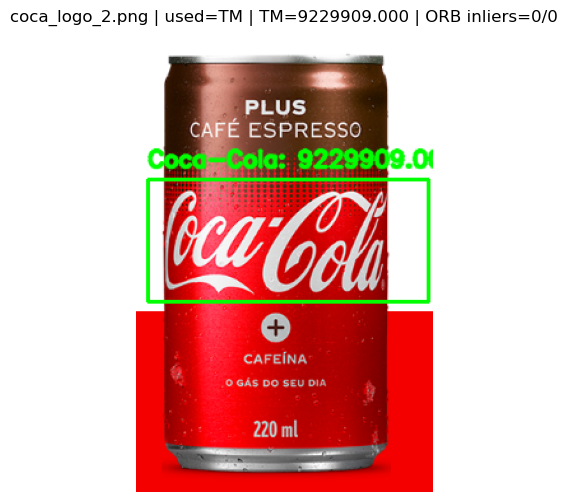

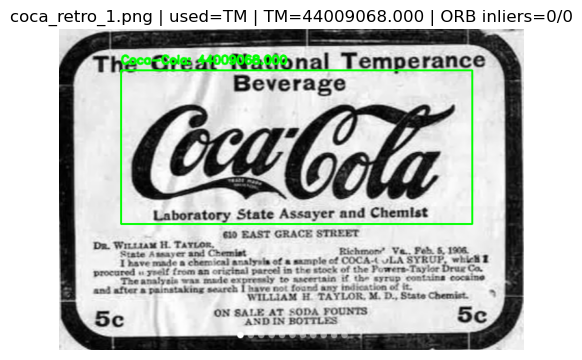

In [71]:
results = []

# Preprocesar template para TM (bordes)
edges_tmpl = prep_edges(tmpl_bgr)

for img_path in images:
    img_bgr = cv2.imread(str(img_path))
    if img_bgr is None:
        print(f"[ERROR] No se pudo leer {img_path}")
        continue

    edges_img = prep_edges(img_bgr)
    best = best_match_multiscale(edges_img, edges_tmpl, TM_SCALES, method=TM_METHOD)
    tm_conf = float(best["max_val"]) if best["max_val"] is not None else 0.0
    tm_pt = best["max_loc"]
    tm_w, tm_h = best["w"], best["h"]

    
    used = "TM"
    final_image = draw_tm_box(img_bgr, tm_pt, tm_w, tm_h, tm_conf, TM_MIN_CONF)
    orb_matches = 0
    orb_inliers = 0
    orb_ok = False

    if not (tm_conf >= TM_MIN_CONF and tm_pt is not None and tm_w and tm_h):
        # ORB fallback
        orb_res = run_orb_homography(img_bgr, tmpl_bgr,
                                     n_features=ORB_N_FEATURES, fast_th=ORB_FAST_THRESHOLD,
                                     min_matches=ORB_MIN_MATCHES, ransac_th=ORB_RANSAC_REPROJ_TH)
        orb_ok = orb_res["ok"]
        orb_matches = orb_res["matches"]
        orb_inliers = orb_res["inliers"]
        if orb_ok and orb_inliers >= ORB_MIN_INLIERS:
            used = "ORB"
            final_image = draw_orb_polygon(img_bgr, orb_res["corners"], orb_inliers, orb_matches)

    
    plt.figure()
    plt.imshow(cv2.cvtColor(final_image, cv2.COLOR_BGR2RGB))
    title = f"{img_path.name} | used={used} | TM={tm_conf:.3f} | ORB inliers={orb_inliers}/{orb_matches}"
    plt.title(title)
    plt.axis("off")
    plt.show()

    # (Opcional) plot de keypoints ORB
    if used == "ORB" and "orb_res" in locals() and SHOW_KEYPOINTS:
        kp1, kp2 = orb_res["kp"]
        # dibujar keypoints en imagen (no matches, solo KP para vista rápida)
        img_kp = cv2.drawKeypoints(img_bgr, kp2, None)
        plt.figure()
        plt.imshow(cv2.cvtColor(img_kp, cv2.COLOR_BGR2RGB))
        plt.title(f"Keypoints ORB en {img_path.name} ({len(kp2)} kp)")
        plt.axis("off")
        plt.show()

    results.append({
        "image": img_path.name,
        "used": used,
        "tm_conf": tm_conf,
        "tm_x": int(tm_pt[0]) if tm_pt else None,
        "tm_y": int(tm_pt[1]) if tm_pt else None,
        "tm_w": int(tm_w) if tm_w else None,
        "tm_h": int(tm_h) if tm_h else None,
        "orb_matches": int(orb_matches),
        "orb_inliers": int(orb_inliers),
    })

In [47]:
#CONCLUSIONES: A PESAR DE AJUSTAR LOS PARÁMETROS, NO SALIÓ DE UNA PARA UN MISMO MÉTODO DE TEMPLATE MATCHING. UTILIZAMOS DOS. 
#TM_CCORR PARA UN GRUPO DE IMÁGENES Y TM_CCOEFF PARA OTRO GRUPO DE IMÁGENES. EN NINGUNO DE LOS DOS METODOS OBTUVIMOS BUENOS 
#RESULTADOS PARA LA IMAGEN COCA-COLA-LOGO.jpg